In [3]:
import os
import imageio
import shutil
import scipy.io
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from matplotlib.colors import Normalize
import matplotlib.animation as animation
from matplotlib.image import imread
from scipy.integrate import quad

import solver.conditions as conditions
import solver.utils as utils
import solver.pinn as pinn
import solver.siren as siren
import solver.geometry as geometry
import solver.timedomain as timedomain
import solver.visualizations as visualizations

import warnings
warnings.filterwarnings("ignore")

In [2]:
def initial_condition_function(x):
    return torch.sin(torch.pi * torch.tensor(x))

def boundary_condition_function(x, t):
    return torch.zeros_like(x)

def analytical_solution(x, t, alpha, L):
    x = torch.tensor(x)
    t = torch.tensor(t)
    u = torch.zeros_like(x)

    for n in range(1, 100):
        B_n, _ = quad(lambda x: initial_condition_function(x) * np.sin(n * np.pi * x / L), 0, L)
        u += 2 / L * B_n * torch.sin(n * np.pi * x / L) * torch.exp(-alpha**2 * (n * np.pi / L)**2 * t)
    return u

In [3]:
geom = geometry.Interval(0.0, 1.0)
period = timedomain.TimeDomain(0.0, 0.5)
alpha = 0.5
n = 1000

# Generate initial conditions
initial_conditions = conditions.InitialConditions()
initial_conditions.set_initial_conditions(geom=geom, time=period, 
                                                       initial_func=initial_condition_function, 
                                                       num_points=n, random=False, device="cuda:0")

# Generate boundary conditions
boundary_conditions = conditions.BoundaryConditions()
boundary_conditions.set_boundary_conditions(geom=geom, time=period, 
                                                         boundary_func=boundary_condition_function, 
                                                         num_points=n, random=False, device="cuda:0")

# Generate equation
equation = conditions.Equation()
equation.set_equation(geom=geom, time=period, num_points=n, random=False, device="cuda:0")

# Generate test
test = conditions.Test()
test.set_test(geom=geom, time=period, num_points=n, random=False, device="cuda:0")

problem = conditions.Problem(initial_conditions, boundary_conditions, 
                             equation, test, geom, period, alpha=alpha)

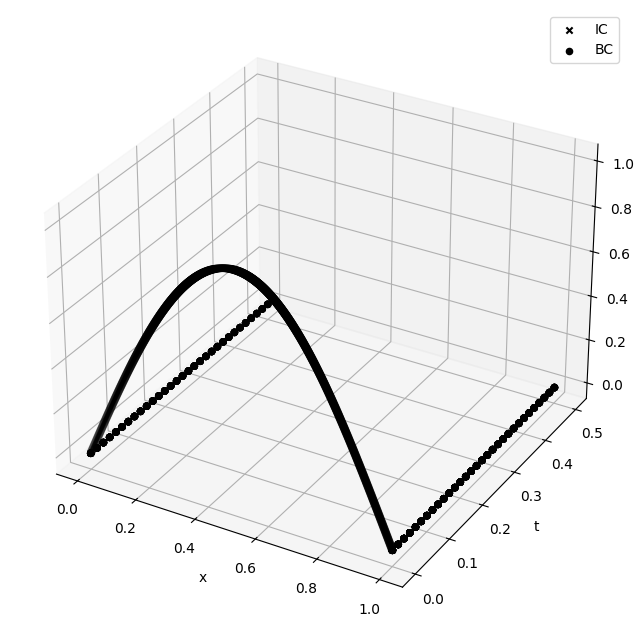

In [4]:
visualizations.solution_surface_plot(problem, None)

In [ ]:
hidden_layers = np.array([1, 2, 4, 6, 8, 10])
# activations = ['tanh', 'sigmoid', 'sin']
activations = ['sin']
neurons_in_layer = np.array([1, 4, 8, 16, 32, 64])

# hidden_layers = np.array([8])
# activations = ['tanh']
# neurons_in_layer = np.array([32])

weights_dir = 'weights'
utils.create_or_clear_folder(weights_dir)

logs_dir = 'logs'
utils.create_or_clear_folder(logs_dir)

l2_norms = {}
for activation in activations:
    for hidden_layer in hidden_layers:
        for neurons in neurons_in_layer:
            if activation == 'sin':
                siren_params = siren.SirenParams(first_omega_0 = 30.0,
                                                 hidden_omega_0 = 30.0,
                                                 outermost_linear = True)
            else:
                siren_params = None

            net_params = utils.NetParams()
            net_params.set_params(input=2,
                      output=1,
                      hidden_layers=[int(neurons) for _ in range(hidden_layer)],
                      epochs=5000,
                      batch_size=100,
                      lr=0.003,
                      activation=activation,
                      training_mode='train',
                      optimizer='Adam', # 'LBFGS', 'Adam' or 'Hybrid'
                      scheduler=None,
                      early_stopping=True,
                      use_rar=False,
                      use_weights_adjuster=False,
                      display_interval=100,
                      model_save_path='models',
                      output_path='out',
                      save_loss=True,
                      initial_weights_path=None,
                      siren_params=siren_params)

            model = pinn.PINN(problem, net_params, device='cuda:0')
            model.train()

            u_pinn = model.predict(problem.test.x, problem.test.t)
            u_analytical = analytical_solution(problem.test.x.cpu().detach().numpy(), 
                                               problem.time.t1, problem.alpha, 
                                               problem.geom.length()).to('cuda:0')

            title = f'model_{len(net_params.hidden_layers)}_{net_params.hidden_layers[0]}_{net_params.activation}'
            
            # Plot of solution
            # utils.comparison_plot(problem.test.x, u_analytical, u_pinn, net_params.output_path)
            
            # Plot loss
            # utils.loss_history_plot(model.get_loss_history(), net_params.output_path)

            l2_norm = torch.sqrt(torch.sum((u_analytical - u_pinn)**2) / len(u_analytical)).item()
            l2_norms[(activation, hidden_layer, neurons)] = l2_norm

            torch.save(model.net.state_dict(), 
                       os.path.join(weights_dir, f'model_{hidden_layer}_{activation}_{neurons}.pt'))

In [7]:
import csv

csv_file_path = 'l2_norms.csv'

with open(csv_file_path, 'a', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    
    csv_writer.writerow(['Activation', 'Hidden Layers', 'Neurons', 'L2_norm'])
    
    for key, value in l2_norms.items():
        activation, hidden_layers, neurons = key
        csv_writer.writerow([activation, hidden_layers, neurons, value])

In [29]:
def plot_aggregated_data(data_path, depend_on, fixed_parameter, fixed_value, aggregate_by):
    df = pd.read_csv(data_path)
    filtered_data = df[df[fixed_parameter] == fixed_value]
    unique_values = filtered_data[aggregate_by].unique()

    markers = ['o', 's', '^', 'v', '<', '>', 'd', 'p', 'h', '*']
    
    for i, value in enumerate(unique_values):
        value_data = filtered_data[filtered_data[aggregate_by] == value]
        
        plt.plot(value_data[depend_on], value_data['L2_norm'], 
                 label=f'{value}', 
                 marker=markers[i % len(markers)])
    
    plt.xlabel(depend_on)
    plt.ylabel('L$^2$')
    plt.title(f'Dependence of L$^2$ on {depend_on} at {fixed_parameter}={fixed_value}')
    plt.legend()
    plt.grid(True)
    plt.show()

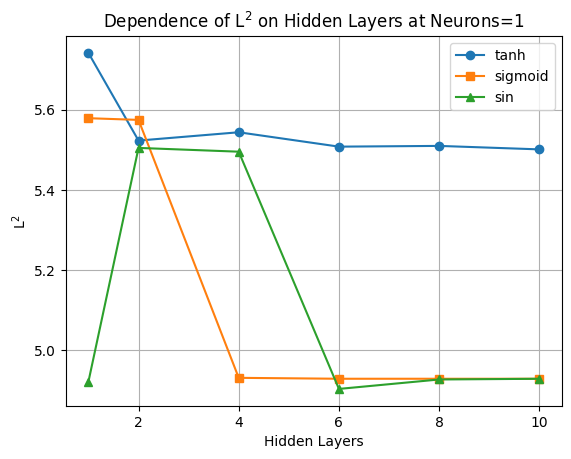

In [31]:
plot_aggregated_data(data_path='l2_norms.csv',
                     depend_on='Hidden Layers',
                     fixed_parameter='Neurons',
                     fixed_value=1,
                     aggregate_by='Activation')